In [51]:
from tensorflow.keras.models import load_model
model = load_model('f:/data/dogs-vs-cats/cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [52]:
img_path = 'f:/data/dogs-vs-cats_small/test/cats/cat.1700.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0) # 이미지를 4D 텐서로 변경한다
img_tensor /= 255.

print(img_tensor.shape) # 이미지 텐서의 크기는 (1, 150, 150, 3)

(1, 150, 150, 3)


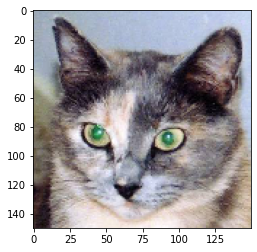

In [53]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [54]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers[:8]] # 상위 8개 층의 출력을 추출한다.
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [55]:
activations = activation_model.predict(img_tensor)

(1, 148, 148, 32)


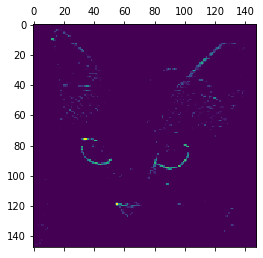

In [56]:
# 고양이 이미지에 대한 첫 번째 합성곱 층의 활성화 값
first_layer_activation = activations[0]
print(first_layer_activation.shape)
# (1, 148, 148, 32)

import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')

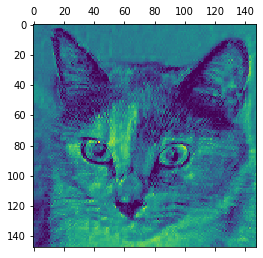

In [57]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')

In [58]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name) # 층의 이름을 그래프 제목으로 사용한다.

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # 특성 맵을 그린다. 
        n_features = layer_activation.shape[-1] # 특성 맵에 있는 특성의 수
        
        size = layer_activation.shape[1] # 특성 맵의 크기는 (1, size, size, n_features)이다.
        
        n_cols = n_features // images_per_row # 활성화 채널을 위한 그리드 크기를 구한다.
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        
        for col in range(n_cols): # 각 활성화를 하나의 큰 그리드에 채운다. 
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
        

In [59]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights = 'imagenet',
      include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[::,:,:, filter_index])

# 입력에 대한 손실의 그래디언트 구하기
grads = K.gradients(loss, model.input)[0]

In [60]:
# 그래디언트 정규화하기
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) # 0 나눗셈을 방지하기 위해 1e-5를 더한다.

In [61]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [62]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128. # 잡음이 섞인 회색 이미지로 시작

step = 1. # 업데이트할 그레디언트의 크기
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [63]:
def deprocess_image(x):
    x -=x.mean()
    x /=(x.std() + 1e-5)
    x *= 0.1
    
    x +=0.5
    x = np.clip(x, 0, 1)
    
    x *=255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [64]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[::,:,:, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
    step = 1. 
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

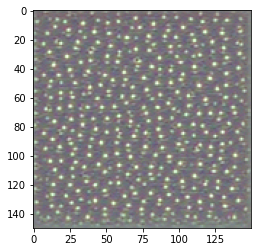

In [65]:
import matplotlib.pyplot as plt

plt.imshow(generate_pattern('block3_conv1', 0))

In [68]:
layer_name = 'block1_conv1'
size = 64
margin = 5

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8') # 결과를 담을 빈 이미지

for i in range(8): # results 그리드의 행을 반복한다.
    for j in range(8): # results 그리드 열 반복
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size) 
        # layer_name에 있는 i + (k*8)번째 필터에 대한 패턴을 생성한다.
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, 
                vertical_start: vertical_end, :] = filter_img
        # results 그리드의 (i,j)번째 위치에 저장한다.

plt/figure(figsize=(20,20))
plt.imshow(results)

ValueError: could not broadcast input array from shape (150,150,3) into shape (64,64,3)

In [69]:
from tensorflow.keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 11s 0us/step


In [73]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np 

img_path = '.././datasets/creative_commons_elephant.jpg' # 이미지 경로

img = image.load_img(img_path, target_size=(224,224)) # 224x224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환된다.

x = image.img_to_array(img) # (224,224,3)크기의 넘파이 float32 배열

x = np.expand_dims(x, axis=0) # 차원을 추가하여 (1,224,224,3) 크기의 배치로 배열을 변환한다.

x = preprocess_input(x) # 데이터 전처리를 한다. (채널별 컬러 정규화를 수행한다.)


In [75]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

print(np.argmax(preds[0]))

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]
386


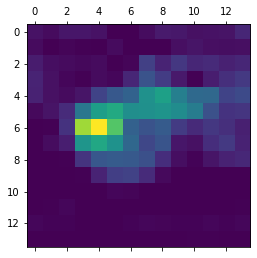

In [78]:
african_elephant_output = model.output[:, 386] # 예측 벡터의 아르피카 코끼리 항목

last_conv_layer = model.get_layer('block5_conv3')
# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트

pooled_grads = K.mean(grads, axis=(0,1,2)) # 특성 맵 채널별 그래디언트 평균값이 담긴 (512,)크기의 벡터

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]]) # 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구한다.

pooled_grads_value, conv_layer_output_value = iterate([x]) # 두 마리 코끼리가 있는 샘플 이미지를 주입하고 2개의 넘파이 배열을 얻는다.

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i] # 아프리카 코끼리 클래스에 대한 채널의 중요도를 특성 맵 배열의 채널에 곱한다.

heatmap = np.mean(conv_layer_output_value, axis=-1) # 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵이다.

# 히트맵 후처리하기
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)


In [90]:
# !pip install opencv-python
import cv2

img = cv2.imread(img_path) # cv2 모듈을 사용하여 원본 이미지를 로드한다.

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # heatmap을 원본 이미지 크기에 맞게 변경한다.

heatmap = np.uint8(255 * heatmap) # heatmap을 RGB 포맷으로 변환한다.

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # 히트맵으로 변환한다.

superimposed_img = heatmap * 0.4 + img # 0.4는 히트맵의 강도이다.

cv2.imwrite('.././datasets/elephant_cam.jpg', superimposed_img) # 디스크에 이미지를 저장한다.

True